In [37]:
import tensorflow as tf
import pandas as pd
import numpy as np
import random
import os
import cv2
import matplotlib.pyplot as plt

# ML LIBRARIES
from keras.utils import plot_model
from tensorflow.keras import models
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import Adam

# AUGMENTING THE DATASET
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import load_img

# CALLBACKS FOR THE MODEL IDK
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint

In [3]:
SEED = 42
CLASS_TYPES = ['malign', 'benign']
root_path = r"D:\Whatever in stock\test\BRAIN SCAN IMAGES\TARP\datasets"

# malign means cancerous
# benign means not cancerous
train_path , test_path = os.path.join(root_path , 'train') , os.path.join(root_path , 'test')

In [4]:
# Image size
image_size = (150, 150)

# Training batch size
batch_size = 32

In [42]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=10,
                                   brightness_range=(0.85, 1.15),
                                   width_shift_range=0.002,
                                   height_shift_range=0.002,
                                   shear_range=12.5,
                                   zoom_range=0,
                                   horizontal_flip=True,
                                   vertical_flip=False,
                                   fill_mode="nearest")

train_generator = train_datagen.flow_from_directory(train_path,
                                                 target_size = image_size,
                                                 batch_size = batch_size,
                                                 class_mode = 'binary',
                                                 shuffle = True)

Found 800 images belonging to 2 classes.


In [27]:
test_datagen = ImageDataGenerator(rescale=1./255)

# applying the generator to testing data with constant seed
test_generator = test_datagen.flow_from_directory(test_path,
                                                  target_size=image_size,
                                                  batch_size=batch_size,
                                                  class_mode="binary",
                                                  shuffle=False,
                                                  seed=SEED)

Found 200 images belonging to 2 classes.


In [11]:
# testing image
image = cv2.imread(os.path.join(train_path,r'no/train_no1.jpg'))
cv2.imshow("test image",image)
cv2.waitKey(0)

-1

In [12]:
print(image.shape)

(630, 630, 3)


In [18]:
image_shape = (image_size[0], image_size[1], 3)

# Training epochs
epochs = 40

In [ ]:

model = models.Sequential([

    Conv2D(32, (4, 4), activation="relu", input_shape=image_shape),
    MaxPooling2D(pool_size=(3, 3)),

    Conv2D(64, (4, 4), activation="relu"),
    MaxPooling2D(pool_size=(3, 3)),

    Conv2D(128, (4, 4), activation="relu"),
    MaxPooling2D(pool_size=(3, 3)),

    Conv2D(128, (4, 4), activation="relu"),
    Flatten(),

    Dense(512, activation="relu"),
    Dropout(0.5, seed=SEED),
    
    Dense(1, activation="sigmoid")
])

model.summary()


d:\Whatever in stock\test\BRAIN SCAN IMAGES\TARP\sam2\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 147, 147, 32)   │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 49, 49, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 46, 46, 64)     │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 15, 15, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 1, 1, 128)      │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 494,433 (1.89 MB)

 Trainable params: 494,433 (1.89 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
optimizer = Adam(learning_rate=0.001, beta_1=0.869, beta_2=0.995)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics= ['accuracy'])

In [28]:
# parameters for the model
steps_per_epoch = train_generator.samples // batch_size
validation_steps = test_generator.samples // batch_size


In [43]:
# Stop training if loss doesn't keep decreasing.
model_es = EarlyStopping(monitor='loss', min_delta=1e-9, patience=8, verbose=True)
model_rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5, verbose=True)

In [33]:
# Training the model
model_history = model.fit(train_generator,
                    steps_per_epoch=steps_per_epoch,
                    epochs=epochs,
                    validation_data=test_generator,
                    validation_steps=validation_steps,
                    callbacks=[model_es, model_rlr])

Epoch 1/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 599ms/step - accuracy: 0.5900 - loss: 0.6804

d:\Whatever in stock\test\BRAIN SCAN IMAGES\TARP\sam2\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


25/25 ━━━━━━━━━━━━━━━━━━━━ 29s 862ms/step - accuracy: 0.5918 - loss: 0.6794 - val_accuracy: 0.5104 - val_loss: 1.0262 - learning_rate: 0.0010
Epoch 2/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 1.5090 - learning_rate: 0.0010
Epoch 3/40


C:\Users\LENOVO\AppData\Local\Programs\Python\Python310\lib\contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 251ms/step - accuracy: 0.7901 - loss: 0.5195 - val_accuracy: 0.4896 - val_loss: 0.9116 - learning_rate: 0.0010
Epoch 4/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 809us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.1250 - val_loss: 1.5014 - learning_rate: 0.0010
Epoch 5/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 251ms/step - accuracy: 0.8634 - loss: 0.3274 - val_accuracy: 0.6042 - val_loss: 0.8262 - learning_rate: 0.0010
Epoch 6/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.2500 - val_loss: 1.9192 - learning_rate: 0.0010
Epoch 7/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 258ms/step - accuracy: 0.8877 - loss: 0.2692 - val_accuracy: 0.6510 - val_loss: 0.6910 - learning_rate: 0.0010
Epoch 8/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.2500 - val_loss: 1.5551 - learning_rate: 0.0010
Epoch 9/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 298ms/step - accuracy: 0.9004 - loss: 

In [34]:
model_history = model.fit(train_generator,
                    steps_per_epoch=steps_per_epoch,
                    epochs=epochs,
                    validation_data=test_generator,
                    validation_steps=validation_steps)

Epoch 1/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 460ms/step - accuracy: 0.9087 - loss: 0.2217 - val_accuracy: 0.6927 - val_loss: 0.7843
Epoch 2/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.2500 - val_loss: 1.9539
Epoch 3/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 241ms/step - accuracy: 0.9341 - loss: 0.1719 - val_accuracy: 0.7812 - val_loss: 0.5355
Epoch 4/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.5000 - val_loss: 1.2900
Epoch 5/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 250ms/step - accuracy: 0.9295 - loss: 0.1953 - val_accuracy: 0.7865 - val_loss: 0.5614
Epoch 6/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.3750 - val_loss: 1.1820
Epoch 7/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 270ms/step - accuracy: 0.9355 - loss: 0.1640 - val_accuracy: 0.8177 - val_loss: 0.4448
Epoch 8/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 

In [35]:
loss, accuracy = model.evaluate(test_generator, steps=test_generator.samples//batch_size)
print(f"Test Loss: {loss:0.5f}")
print(f"Test Accuracy: {accuracy:0.5f}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.9129 - loss: 0.3775
Test Loss: 0.68990
Test Accuracy: 0.85417


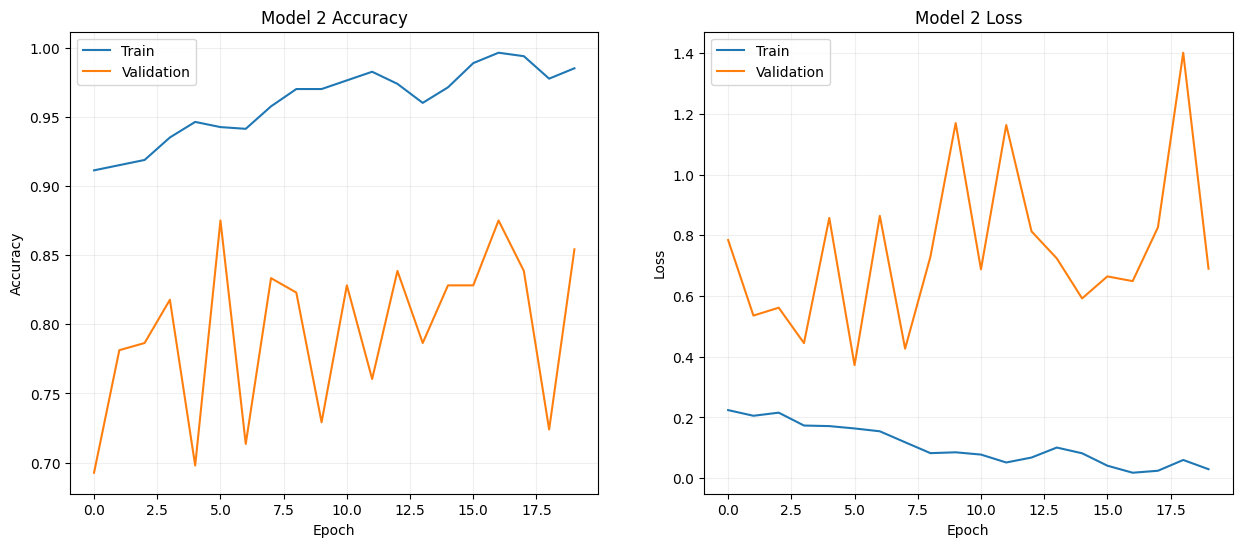

In [ ]:
_, ax = plt.subplots(ncols=2, figsize=(15, 6))

# plotting the accuracy
ax[0].plot(model_history.history['accuracy'][::2])
ax[0].plot(model_history.history['val_accuracy'][::2])
ax[0].set_title('Model 2 Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Train', 'Validation'])
ax[0].grid(alpha=0.2)

# plotting the losses
ax[1].plot(model_history.history['loss'][::2])
ax[1].plot(model_history.history['val_loss'][::2])
ax[1].set_title('Model 2 Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend(['Train', 'Validation'])
ax[1].grid(alpha=0.2)

plt.show()